In [50]:
import librosa
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import csv
import soundfile as sf


import warnings
warnings.filterwarnings('ignore')

In [42]:
cur_dir = os.getcwd()
hc_directory = os.path.join(cur_dir, "../Data/ReadText/HC")
pd_directory = os.path.join(cur_dir, "../Data/ReadText/PD")
print(hc_directory)

d:\Android\Pipeline\PD classifier\../Data/ReadText/HC


In [43]:
# hc_files = [os.path.join(hc_directory, filename) for filename in os.listdir(hc_directory) if filename.endswith(".wav")]
# pd_files = [os.path.join(pd_directory, filename) for filename in os.listdir(pd_directory) if filename.endswith(".wav")]
hc_files = [filename for filename in os.listdir(hc_directory) if filename.endswith(".wav")]
pd_files = [filename for filename in os.listdir(pd_directory) if filename.endswith(".wav")]


In [45]:
# Функция для аугментации данных
def augment_data(input_dir, audio_file, output_dir, n_augmentations=5):
    # Загрузка аудиозаписи
    input = os.path.join(input_dir, audio_file)
    y, sr = librosa.load(audio_file)
    
    # Создание директории для сохранения аугментированных данных, если она не существует
    os.makedirs(output_dir, exist_ok=True)
    
    # Аугментация данных
    for i in range(n_augmentations):
        # Изменение скорости
        speed_factor = np.random.uniform(0.7, 1.3)  # случайный фактор скорости
        y_speed = librosa.effects.time_stretch(y, speed_factor)
        
        # Изменение тональности
        pitch_factor = np.random.uniform(-2, 2)  # случайный фактор изменения тональности
        y_pitch = librosa.effects.pitch_shift(y, sr, n_steps=pitch_factor)
        
        # Добавление шума
        noise = np.random.randn(len(y))
        y_noisy = y + 0.005 * noise
        
        # Сохранение аугментированных данных
        librosa.output.write_wav(os.path.join(output_dir, f"augmented_{i}_speed.wav"), y_speed, sr)
        librosa.output.write_wav(os.path.join(output_dir, f"augmented_{i}_pitch.wav"), y_pitch, sr)
        librosa.output.write_wav(os.path.join(output_dir, f"augmented_{i}_noisy.wav"), y_noisy, sr)

# Пример использования
# audio_file = "original_audio.wav"
# output_dir = "augmented_data"
# augment_data(audio_file, output_dir)

In [58]:
# Функция для разделения аудиозаписи на фрагменты
def split_audio(input_dir, audio_file, output_dir, duration=5):
    # Загрузка аудиозаписи
    input = os.path.join(input_dir, audio_file)
    y, sr = librosa.load(input, sr=None)

    # Вычисление количества фрагментов
    n_samples = len(y)
    n_frames = int(np.ceil(n_samples / (duration * sr)))

    # Создание директории для сохранения фрагментов, если она не существует
    os.makedirs(output_dir, exist_ok=True)

    # Разделение на фрагменты и сохранение
    for i in range(n_frames):
        start = i * duration * sr
        end = min((i + 1) * duration * sr, n_samples)
        fragment = y[start:end]

        # Сохранение фрагмента
        sf.write(os.path.join(output_dir, f"{audio_file}_fragment_{i}.wav"), fragment, sr)

# # Пример использования
# audio_file = "original_audio.wav"
# output_dir = "audio_fragments"
# split_audio(audio_file, output_dir, duration=5)


In [59]:
augment_dir = "../Data/Augment"
hc_aug = augment_dir + "/HC"
pd_aug = augment_dir + "/PD"
augment_strategy = split_audio

for filename in hc_files:
    augment_strategy(hc_directory, filename, hc_aug)

for filename in pd_files:
    augment_strategy(pd_directory, filename, pd_aug)

In [11]:
def extract_features(directory, file):
    name = f'{directory}/{file}'
    y, sr = librosa.load(name, mono=True, duration=5)
    
    features = [] 
    features.append(file) # filename
    features.extend([np.mean(e) for e in librosa.feature.mfcc(y=y, sr=sr, 
                                                              n_mfcc=20)])  # mfcc_mean<0..20>
    features.extend([np.std(e) for e in librosa.feature.mfcc(y=y, sr=sr,
                                                             n_mfcc=20)])   # mfcc_std
    features.append(np.mean(librosa.feature.spectral_centroid(y=y, sr=sr).T,
                            axis = 0)[0])     # cent_mean
    features.append(np.std(librosa.feature.spectral_centroid(y=y,sr=sr).T,
                           axis = 0)[0])       # cent_std
    features.append(scipy.stats.skew(librosa.feature.spectral_centroid(y=y,sr=sr).T,
                                     axis = 0)[0])    # cent_skew
    features.append(np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr).T, 
                            axis = 0)[0])      # rolloff_mean
    features.append(np.std(librosa.feature.spectral_rolloff(y=y, sr=sr).T, 
                           axis = 0)[0])       # rolloff_std
    

    features.append(directory.split('/')[-1])
    return features

In [60]:

hc_files = [filename for filename in os.listdir(hc_aug) if filename.endswith(".wav")]
pd_files = [filename for filename in os.listdir(pd_aug) if filename.endswith(".wav")]

In [62]:
buffer = []
buffer_size = 20
buffer_counter = 0

# Создание заголовка для файла CSV.
header = ['filename']
header.extend([f'mfcc_mean{i}' for i in range(1, 21)])
header.extend([f'mfcc_std{i}' for i in range(1, 21)])
header.extend(['cent_mean', 'cent_std', 'cent_skew', 'rolloff_mean', 'rolloff_std',
               'label'])

with open('dataset.csv', 'w', newline='') as file:
    writer = csv.writer(file, delimiter=',')
    writer.writerow(header)
    for directory, files in [(hc_directory, hc_files), (pd_directory, pd_files)]:
        for file in files:
            features = extract_features(directory, file)
            if buffer_counter + 1 == buffer_size:
                buffer.append(features)
                writer.writerows(buffer)
                print(f"- [{directory.split('/')[-1]}] Write {len(buffer)} rows")
                buffer = []
                buffer_counter = 0
            else:
                buffer.append(features)
                buffer_counter += 1
        if buffer:
            writer.writerows(buffer)
            print(f"- [{directory.split('/')[-1]}] Write {len(buffer)} rows") 
        print(f"- [{directory.split('/')[-1]}] Writing complete")
        buffer = []
        buffer_counter = 0

- [HC] Write 20 rows
- [HC] Write 20 rows
- [HC] Write 20 rows
- [HC] Write 20 rows
- [HC] Write 20 rows
- [HC] Write 20 rows
- [HC] Write 20 rows
- [HC] Write 20 rows
- [HC] Write 20 rows
- [HC] Write 20 rows
- [HC] Write 20 rows
- [HC] Write 20 rows
- [HC] Write 20 rows
- [HC] Write 20 rows
- [HC] Write 20 rows
- [HC] Write 20 rows
- [HC] Write 5 rows
- [HC] Writing complete
- [PD] Write 20 rows
- [PD] Write 20 rows
- [PD] Write 20 rows
- [PD] Write 20 rows
- [PD] Write 20 rows
- [PD] Write 20 rows
- [PD] Write 20 rows
- [PD] Write 20 rows
- [PD] Write 20 rows
- [PD] Write 20 rows
- [PD] Write 20 rows
- [PD] Write 20 rows
- [PD] Write 20 rows
- [PD] Write 12 rows
- [PD] Writing complete


## SVM в студию!

In [63]:
data = pd.read_csv('dataset.csv')
data

,filename,mfcc_mean1,mfcc_mean2,mfcc_mean3,mfcc_mean4,mfcc_mean5,mfcc_mean6,mfcc_mean7,mfcc_mean8,mfcc_mean9,...,mfcc_std17,mfcc_std18,mfcc_std19,mfcc_std20,cent_mean,cent_std,cent_skew,rolloff_mean,rolloff_std,label
0,ID00_hc_0_0_0.wav_fragment_0.wav,-505.60168,101.291030,50.592910,37.739680,0.051331,-22.537048,-8.030754,-1.131811,-5.954812,...,7.121746,6.638588,5.072137,6.356627,2211.914194,1832.217635,1.469049,4047.594198,3185.282069,HC
1,ID00_hc_0_0_0.wav_fragment_1.wav,-526.33500,120.734470,39.729935,38.860188,-1.541198,-28.654590,-11.724535,-3.290982,-2.435851,...,5.833153,7.408469,5.759777,5.168825,1620.740217,952.330312,1.411596,3306.094360,2396.266577,HC
2,ID00_hc_0_0_0.wav_fragment_10.wav,-522.95514,107.313896,43.815940,37.457930,-0.402876,-19.633700,-5.897346,-1.330659,-4.074365,...,7.295900,6.228197,5.408964,6.013413,2003.530572,1455.232865,2.015543,4039.220174,2604.207606,HC
3,ID00_hc_0_0_0.wav_fragment_11.wav,-523.35430,94.964370,46.325730,43.377060,1.505108,-19.889784,-6.258972,-1.573064,-3.512381,...,6.487541,6.090934,6.408428,5.736011,2412.688159,1803.200136,1.386976,4652.368164,2997.513756,HC
4,ID00_hc_0_0_0.wav_fragment_12.wav,-499.33910,86.574980,41.172382,38.570103,3.425327,-20.803650,-6.095923,-0.532638,-0.675026,...,6.617273,5.837942,5.213241,5.291357,2739.866424,1933.916584,1.217641,5321.642049,2901.083687,HC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,ID34_pd_2_0_0.wav_fragment_5.wav,-462.46478,110.393210,7.583053,23.849077,20.363802,-9.787520,-20.986277,7.165211,7.453133,...,7.226569,5.565321,7.187790,7.587934,1906.033248,1133.879279,2.144978,3515.943400,2144.339788,PD
593,ID34_pd_2_0_0.wav_fragment_6.wav,-448.92447,98.730140,14.946258,12.349708,21.769258,-1.945524,-24.628014,1.051940,7.218893,...,7.450013,5.065847,6.309899,7.474318,2536.833843,1972.904380,1.445094,4329.519653,2927.685694,PD
594,ID34_pd_2_0_0.wav_fragment_7.wav,-561.19610,96.505356,22.125046,17.279335,18.185617,3.880400,-11.964452,4.419256,5.725984,...,5.552582,4.641446,8.218346,6.063486,2361.279914,1178.266336,2.112881,5307.884725,2044.969332,PD
595,ID34_pd_2_0_0.wav_fragment_8.wav,-438.78424,106.284580,0.434917,7.671229,24.823013,-4.614595,-24.317406,7.486002,10.327330,...,7.391715,6.762380,7.125229,7.382754,2324.798164,1796.512136,1.832911,4011.207072,2665.274299,PD


In [64]:
data['label'].value_counts()

label
HC    325
PD    272
Name: count, dtype: int64

In [65]:
y = data['label'].values
X = data[['mfcc_mean1', 'mfcc_mean2', 'mfcc_mean3', 'mfcc_mean4',
       'mfcc_mean5', 'mfcc_mean6', 'mfcc_mean7', 'mfcc_mean8', 'mfcc_mean9',
       'mfcc_mean10', 'mfcc_mean11', 'mfcc_mean12', 'mfcc_mean13',
       'mfcc_mean14', 'mfcc_mean15', 'mfcc_mean16', 'mfcc_mean17',
       'mfcc_mean18', 'mfcc_mean19', 'mfcc_mean20', 'mfcc_std1', 'mfcc_std2',
       'mfcc_std3', 'mfcc_std4', 'mfcc_std5', 'mfcc_std6', 'mfcc_std7',
       'mfcc_std8', 'mfcc_std9', 'mfcc_std10', 'mfcc_std11', 'mfcc_std12',
       'mfcc_std13', 'mfcc_std14', 'mfcc_std15', 'mfcc_std16', 'mfcc_std17',
       'mfcc_std18', 'mfcc_std19', 'mfcc_std20', 'cent_mean', 'cent_std',
       'cent_skew', 'rolloff_mean', 'rolloff_std']]

In [66]:
from sklearn import preprocessing
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:2]

array([[-5.60051015e-01,  7.64462133e-01,  1.77077805e+00,
         1.42382181e+00, -1.08196425e+00, -2.34322409e+00,
        -4.76324958e-01,  1.06651487e-01, -2.01939626e-01,
         5.56509511e-01, -9.24944743e-02, -3.86779103e-01,
        -7.17127392e-01,  2.18117266e-01, -9.95028275e-01,
        -1.14074400e+00, -5.09482754e-01, -4.45085118e-01,
         4.17738777e-01, -1.37026477e+00, -1.31438054e+00,
         9.20682602e-01, -1.53906353e-01, -2.89134462e-01,
         1.07669430e-01,  1.11941904e+00, -9.80340766e-01,
        -1.31344967e+00, -6.84383249e-01, -1.27095410e+00,
        -3.55797258e-01, -7.13628437e-01, -8.63485889e-01,
        -6.25765639e-01, -6.55142008e-01,  4.38016957e-01,
        -2.74588266e-01, -3.11624244e-01, -1.68097767e+00,
        -9.78911780e-02, -3.15955032e-01,  1.03951562e+00,
         3.93515750e-02, -7.75632398e-01,  1.88963201e+00],
       [-9.49598211e-01,  2.01973446e+00,  9.49126415e-01,
         1.54750342e+00, -1.24378693e+00, -3.00725110e+

In [67]:
from sklearn.model_selection import train_test_split
# Разделение набора данных на тренировочные и тестовые наборы (train/test split)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2,
                                                            random_state=17)

# размер тренировочных и тестовых наборов (количество строк, колонок):
print ('Train set:', X_train.shape, y_train.shape)    
print ('Test set:', X_test.shape, y_test.shape)

from sklearn import svm
clf = svm.SVC(kernel='rbf')   #  функция ядра - RBF (радиальная базисная функция)
clf.fit(X_train, y_train)     # Обучение модели на тренировочном наборе
yhat = clf.predict(X_test)    # для прогнозирования новых значений:
yhat [0:10]

Train set: (477, 45) (477,)
Test set: (120, 45) (120,)


array(['PD', 'HC', 'HC', 'PD', 'HC', 'HC', 'PD', 'HC', 'PD', 'PD'],
      dtype=object)

In [68]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, clf.predict(X_train)))
print("Test set Accuracy: ",metrics.accuracy_score(y_test, yhat) )

Train set Accuracy:  0.9958071278825996
Test set Accuracy:  0.95


In [69]:
# функция для графического представления матрицы несоответствия
def plot_confusion_matrix(y_true, y_pred, classes, normalize = False, cmap = plt.cm.Blues):
    """
    Функция выводит и строит матрицу несоответствий
    """

    # Вычисление матрицы несоответствий
    cm = metrics.confusion_matrix(y_true, y_pred)
    print('Confusion matrix:\n', cm)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'

    fig, ax = plt.subplots()
    plt.title(title)
    im = ax.imshow(cm, interpolation = 'nearest', cmap = cmap)
    ax.figure.colorbar(im, ax = ax)
    # We want to show all ticks...
    ax.set(xticks = np.arange(cm.shape[1]),
           yticks = np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels = classes, yticklabels = classes,
           ylabel = 'True label',
           xlabel = 'Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation = 45, ha = 'right',
             rotation_mode = 'anchor')

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha = 'center', va = 'center',
                    color = 'white' if cm[i, j] > thresh else 'black')
    fig.tight_layout()
    plt.show()
    #return cm

Confusion matrix:
 [[59  2]
 [ 4 55]]


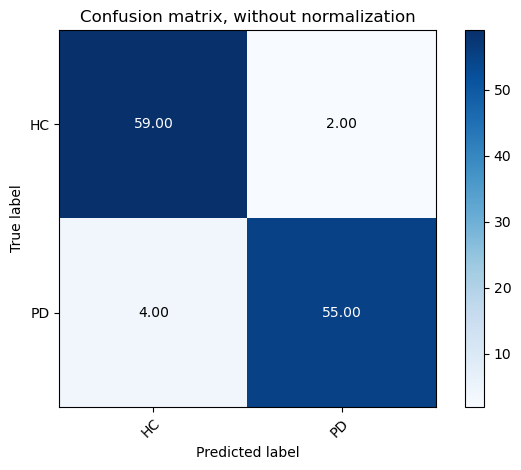

In [70]:
from sklearn.metrics import classification_report,confusion_matrix

plot_confusion_matrix(y_test, yhat, ["HC", "PD"])